In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn
seaborn.set_style("white")
seaborn.set_context("paper")

plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_nichols_data, load_kato_data
import zimmer.plotting as zplt
from zimmer.util import cached

from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [2]:
# Specify hyperparameters
results_dir = "results/combined/2018-10-09/"
figures_dir = os.path.join(results_dir, "figures")

In [3]:
groups = ["n2_1_prelet", 
          "n2_2_let",
          "npr1_1_prelet",
          "npr1_2_let"]

worms_and_groups = [(i, "n2_1_prelet") for i in range(11)] + \
                   [(i, "n2_2_let") for i in range(12)] + \
                   [(i, "npr1_1_prelet") for i in range(10)] + \
                   [(i, "npr1_2_let") for i in range(11)]
worm_names = ["{} worm {}".format(group, i) for (i, group) in worms_and_groups]

In [4]:
# Load the data
ys_nichols, ms_nichols, us_nichols, z_trues_nichols, z_true_key_nichols, neuron_names_nichols = \
    load_nichols_data(worms_and_groups, worm_names, include_unnamed=False, signal="dff")

Only including named neurons.
73 neurons across all 44 worms


In [5]:
ys_kato, ms_kato, z_trues_kato, z_true_key_kato, neuron_names_kato = \
    load_kato_data(include_unnamed=False, signal="dff")
    
# Kato recorded at 21% oxygen concentration
us_kato = [21 * np.ones(y.shape[0]) for y in ys_kato]

Only including named neurons.
59 neurons across all 5 worms


# Combine the two datasets

In [6]:
neuron_names = np.unique(np.concatenate((neuron_names_nichols, neuron_names_kato)))
names_to_inds = dict([(name, ind) for ind, name in enumerate(neuron_names)])
N = len(neuron_names)

In [7]:
z_true_key = dict(Rev=0,
                  Fwd=1,
                  VT=2,
                  DT=3,
                  Q=4,
                  Other=5)

z_map_kato=dict(REVSUS="Rev",
                SLOW="Fwd",
                FWD="Fwd",
                VT="VT",
                DT="DT",
                REV2="Rev",
                REV1="Rev",
                NOSTATE="Other")

z_map_nichols=dict([("Quiescence", "Q"),
                    ("Forward", "Fwd"),
                    ("Reversal", "Rev"),
                    ("Ventral turn", "VT"),
                    ("Dorsal turn", "DT"),
                    ("undefined turn", "Other")])

In [8]:
ys = []
ms = []
us = []
z_trues = []
papers = []

kato_inds = np.array([names_to_inds[name] for name in neuron_names_kato], dtype=int)
for y, m, u, z in zip(ys_kato, ms_kato, us_kato, z_trues_kato):
    T = y.shape[0]
    yy = np.zeros((T, N))
    yy[:, kato_inds] = y    
    mm = np.zeros((T, N), dtype=bool)
    mm[:, kato_inds] = m
    
    ys.append(yy)
    ms.append(mm)
    us.append(u)
    
    znew = -1 * np.ones(T, dtype=int)
    for k, name in enumerate(z_true_key_kato):
        newname = z_map_kato[name]
        znew[z == k] = z_true_key[newname]
    assert np.all(znew >= 0)
    z_trues.append(znew)
    papers.append("kato")
    
# Append Nichols data
nichols_inds = np.array([names_to_inds[name] for name in neuron_names_nichols], dtype=int)
for y, m, u, z in zip(ys_nichols, ms_nichols, us_nichols, z_trues_nichols):
    T = y.shape[0]
    yy = np.zeros((T, N))
    yy[:, nichols_inds] = y    
    mm = np.zeros((T, N), dtype=bool)
    mm[:, nichols_inds] = m
    
    ys.append(yy)
    ms.append(mm)
    us.append(u)

    znew = -1 * np.ones(T, dtype=int)
    for k, name in enumerate(z_true_key_nichols):
        newname = z_map_nichols[name]
        znew[z == k] = z_true_key[newname]
    z_trues.append(znew)
    assert np.all(znew >= 0)

    papers.append("nichols")

In [9]:
with open(os.path.join(results_dir, "z_trues.pkl"), "wb") as f:
    pickle.dump((z_trues, z_true_key, z_map_kato, z_map_nichols), f)
    

In [10]:
with open(os.path.join(results_dir, "us.pkl"), "wb") as f:
    pickle.dump(us, f)

In [11]:
np.bincount(np.concatenate(z_trues), minlength=6)

array([39947, 48628,  9906,  6823, 51909,  1495])

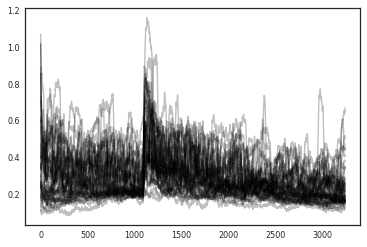

In [12]:
for w in range(5, len(ys)):
    yw = ys[w].copy()
    yw[~ms[w]] = np.nan
    plt.plot(np.nanmean(yw, axis=1), alpha=.25, c='k')

In [13]:
ys = [trend_filter(y, npoly=1, nexp=4) for y in ys]
# ys = [standardize(y, m) for y, m in zip(ys, ms)]
# K_true = len(z_true_key)
K_true = 8
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

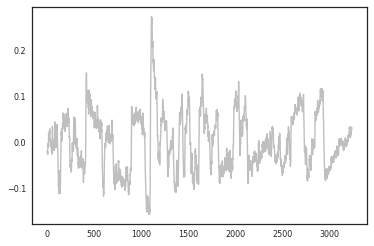

In [26]:
for w in range(31, 32):
    yw = ys[w].copy()
    yw[~ms[w]] = np.nan
    plt.plot(np.nanmean(yw, axis=1), alpha=.25, c='k')

In [15]:
# Split into train and test
np.random.seed(0)
chunk = 250
train_frac = 0.7
val_frac = 0.15
all_ys = []
all_ms = []
all_choices = []
for y, m in zip(ys, ms):
    T = y.shape[0]
    C = 0
    for start in range(0, T, chunk):
        stop = min(start+chunk, T)
        all_ys.append(y[start:stop])
        all_ms.append(m[start:stop])
        C += 1
        
    # assign some of the data to train, val, and test
    choices = -1 * np.ones(C)
    choices[:int(train_frac * C)] = 0
    choices[int(train_frac * C):int((train_frac + val_frac) * C)] = 1
    choices[int((train_frac + val_frac) * C):] = 2
    choices = choices[np.random.permutation(C)]
    all_choices.append(choices)

all_choices = np.concatenate(all_choices)
get = lambda arr, chc: [x for x, c in zip(arr, all_choices) if c == chc]

train_ys = get(all_ys, 0)
train_ms = get(all_ms, 0)

val_ys = get(all_ys, 1)
val_ms = get(all_ms, 1)

test_ys = get(all_ys, 2)
test_ms = get(all_ms, 2)

# Empirical correlation

In [27]:
def compute_covariance():
    C = np.nan * np.ones((N, N))
    
    for i in range(N):
        for j in range(N):
            Ei, Ej, Eii, Ejj, Eij = 0, 0, 0, 0, 0
            n = 0
            for y, m in zip(ys, ms):
                if not np.any(m[:,i] & m[:, j]):
                    continue
                inds = m[:, i] & m[:, j]
                Ei += np.sum(y[inds, i])
                Ej += np.sum(y[inds, j])
                Eii += np.sum(y[inds, i] * y[inds, i])
                Ejj += np.sum(y[inds, j] * y[inds, j])
                Eij += np.sum(y[inds, i] * y[inds, j])
                n += np.sum(inds.astype(int))
            
            if n > 0:
                Ei /= n
                Ej /= n
                Eii /= n
                Ejj /= n
                Eij /= n
                C[i, j] = (Eij - Ei * Ej) 
    
    return C

_cov = cached(results_dir, "cov")(compute_covariance)
emp_cov = _cov()

In [28]:
def compute_correlation():
    C = np.nan * np.ones((N, N))
    
    for i in range(N):
        for j in range(N):
            Ei, Ej, Eii, Ejj, Eij = 0, 0, 0, 0, 0
            n = 0
            for y, m in zip(ys, ms):
                if not np.any(m[:,i] & m[:, j]):
                    continue
                inds = m[:, i] & m[:, j]
                Ei += np.sum(y[inds, i])
                Ej += np.sum(y[inds, j])
                Eii += np.sum(y[inds, i] * y[inds, i])
                Ejj += np.sum(y[inds, j] * y[inds, j])
                Eij += np.sum(y[inds, i] * y[inds, j])
                n += np.sum(inds.astype(int))
            
            if n > 0:
                Ei /= n
                Ej /= n
                Eii /= n
                Ejj /= n
                Eij /= n
                C[i, j] = (Eij - Ei * Ej) / np.sqrt(Eii - Ei**2) / np.sqrt(Ejj - Ej**2)
    
    return C

_corr = cached(results_dir, "corr")(compute_correlation)
emp_corr = _corr()
                

# PCA 

(array([18.,  5.,  7.,  6.,  7.,  3.,  5.,  3.,  3.,  2.]),
 array([0.        , 0.04996004, 0.09992007, 0.14988011, 0.19984015,
        0.24980018, 0.29976022, 0.34972026, 0.3996803 , 0.44964033,
        0.49960037]),
 <a list of 10 Patch objects>)

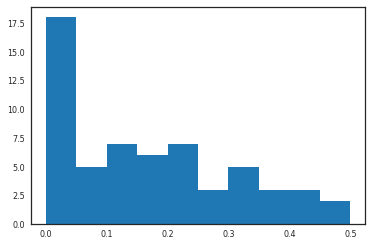

In [29]:
plt.hist(ys_kato[1].std(0))

(array([35.,  3., 10.,  5.,  5.,  2.,  3.,  4.,  4.,  2.]),
 array([0.        , 0.0486329 , 0.0972658 , 0.14589869, 0.19453159,
        0.24316449, 0.29179739, 0.34043029, 0.38906318, 0.43769608,
        0.48632898]),
 <a list of 10 Patch objects>)

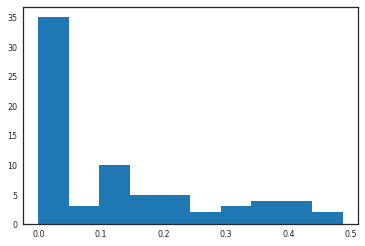

In [30]:
plt.hist(ys_nichols[1].std(0))

In [31]:
# Run PCA to get a 3d projection of the data
from ssm.preprocessing import pca_with_imputation
_pca = cached(results_dir, "pca_D{}".format(20))(pca_with_imputation)
pca, x_fulls = _pca(20, ys, ms, num_iters=100)

([<matplotlib.axis.XTick at 0x7f81a5ba0d68>,
 <a list of 21 Text xticklabel objects>)

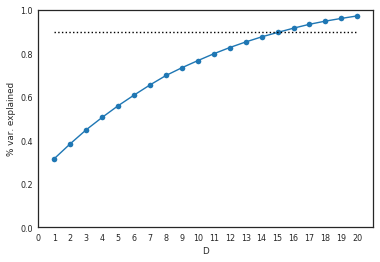

In [32]:
# Determine number of PCs to use
plt.plot(np.arange(1, 21), np.cumsum(pca.explained_variance_ratio_), '-o')
plt.plot(np.arange(1, 21), 0.9 * np.ones(20), ':k')
plt.xlabel("D")
plt.ylabel("% var. explained")
plt.ylim(0,1)
plt.xlim(1, 21)
plt.xticks(np.arange(21))

In [33]:
D = 15
xs = [x[:,:D] for x in x_fulls]

In [34]:
from scipy.ndimage import gaussian_filter1d
xs_smooth = [gaussian_filter1d(x, 3, axis=0) for x in xs]

In [35]:
# To compute the correlation under the PCA model, we need the covariance of the PCA embeddings
C_pca = pca.components_.T[:, :D]
L_x = np.linalg.cholesky(np.cov(np.vstack(xs).T))
C_pca = C_pca.dot(L_x)
Cn_pca = C_pca / np.linalg.norm(C_pca, ord=2, axis=1, keepdims=True)
pca_corr = Cn_pca.dot(Cn_pca.T)

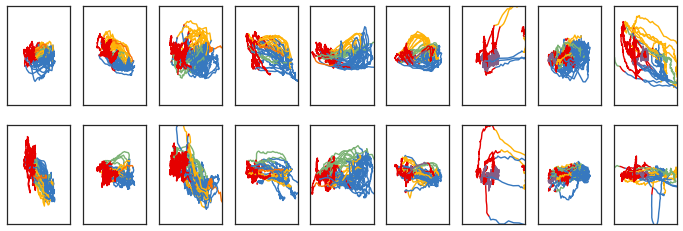

In [41]:
w_to_plot = np.concatenate((np.arange(5), 5 + 1 + np.array([0, 11, 23, 33])))
plt.figure(figsize=(12, 4))
for i, w in enumerate(w_to_plot): 
    ax = plt.subplot(2, len(w_to_plot), i+1)
    zplt.plot_2d_continuous_states(xs[w], z_trues[w], xlims=(-3, 3), ylims=(-3, 3), inds=(0, 1), ax=ax)
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(2, len(w_to_plot), len(w_to_plot) + i+1)
    zplt.plot_2d_continuous_states(xs[w], z_trues[w], xlims=(-3, 3), ylims=(-3, 3), inds=(0, 3), ax=ax)
    plt.xticks([])
    plt.yticks([])

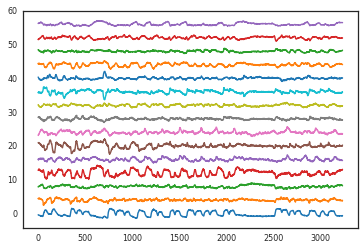

In [39]:
plt.plot(xs[0] + 4 * np.arange(15))

# Factor Analysis

In [ ]:
# Fit a test model
def fit_factor_analysis(D, num_gibbs_iters=20, num_em_iters=100):
    
    # Special case D == 0
    if D == 0:
        mu = np.zeros(N)
        Sigma = np.diag(np.nanvar(np.vstack(train_ys), axis=0))
        
        lp = 0
        for y, m in zip(train_ys, train_ms):
            mu_i = mu[m[0]]
            Sigma_i = Sigma[np.ix_(m[0], m[0])]
            lp += np.sum(multivariate_normal.logpdf(y[:, m[0]], mu_i, Sigma_i))
        
        val_ll = 0
        for y, m in zip(val_ys, val_ms):
            mu_i = mu[m[0]]
            Sigma_i = Sigma[np.ix_(m[0], m[0])]
            val_ll += np.sum(multivariate_normal.logpdf(y[:, m[0]], mu_i, Sigma_i))
        
        return Sigma, np.array([lp]), val_ll
        
    # For D > 1, fit a factor analysis model
    from pybasicbayes.models import FactorAnalysis
    fa = FactorAnalysis(N, D)
    for y, m in zip(train_ys, train_ms):
        fa.add_data(y, mask=m.astype(bool))

    lps = []
    for _ in tqdm(range((num_gibbs_iters))):
        fa.resample_model()
        lps.append(fa.log_likelihood())

    for _ in tqdm(range((num_em_iters))):
        fa.EM_step()
        lps.append(fa.log_likelihood())

    # Compute marginal likelihood of validation data
    mu = np.zeros(N)
    Sigma = fa.W.dot(fa.W.T) + np.diag(fa.sigmasq)
    
    val_ll = 0
    for y, m in zip(val_ys, val_ms):
        m0 = m[0]
        mu_i = mu[m0]
        Sigma_i = Sigma[np.ix_(m0, m0)]
        vll = multivariate_normal.logpdf(y[:, m0], mu_i, Sigma_i)
        assert vll.shape == (y.shape[0],)
        val_ll += np.sum(vll)
    
    return fa, lps, val_ll

Ds = [10]
fas = []
lpss = []
val_lls = []
for D in Ds:
    print("Fitting FA with D=", D)
    _fa = cached(results_dir, "fa_D{}".format(D))(fit_factor_analysis)
    fa, lps, val_ll = _fa(D)
    fas.append(fa)
    lpss.append(lps)
    val_lls.append(val_ll)

In [ ]:
# for D, lps in zip(Ds, lpss):
#     plt.plot(lps, label="D={}".format(D))
# #     plt.xlim(21, 120)
# plt.legend()

# plt.figure()
# plt.plot(Ds, val_lls)
# ll_95 = np.min(val_lls[1:]) + 0.95 * (np.max(val_lls) - np.min(val_lls[1:]))
# plt.plot(Ds, ll_95 * np.ones_like(Ds), ':k')
# plt.legend()

In [ ]:
# Find an orthogonal emission matrix from the factor analysis loadings
C_fa = fa.W
Sigma = np.dot(C_fa, C_fa.T) + np.diag(fa.sigmasq)
evals, evecs = np.linalg.eigh(Sigma, )
inds = np.argsort(evals)[::-1][:D]
Cstar_fa = evecs[:, inds]

# Find the linear transformation that maps C to Cstar
#    Cstar = C \dot R
#    Cstar R^{-1} = C
#    y = Cx = Cstar R^{-1} x
R, _, _, _ = np.linalg.lstsq(C_fa, Cstar_fa)
Ri = np.linalg.inv(R)

# Counter rotate the continuous latent states
xs_fa = [d.Z.dot(Ri.T) for d in fa.data_list]

# Compute the correlation under the FA model
Cn_fa = C_fa / np.linalg.norm(C_fa, ord=2, axis=1, keepdims=True)
fa_corr = Cn_fa.dot(Cn_fa.T)

In [ ]:
plt.plot(xs_fa[28] + np.arange(10))

In [ ]:
for w in range(5, W):
    yw = ys[w].copy()
    yw[~ms[w]] = np.nan
    plt.plot(np.nanmean(yw, axis=1), alpha=.25, c='k')

In [ ]:
w_to_plot = np.concatenate((np.arange(5), 5 + 3 + np.array([0, 11, 23, 33])))
plt.figure(figsize=(12, 4))
for i, w in enumerate(w_to_plot): 
    ax = plt.subplot(2, len(w_to_plot), i+1)
    zplt.plot_2d_continuous_states(xs_fa[w], z_trues[w], xlims=(-2, 2), ylims=(-2, 2), inds=(0, 1), ax=ax)
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(2, len(w_to_plot), len(w_to_plot) + i+1)
    zplt.plot_2d_continuous_states(xs_fa[w], z_trues[w], xlims=(-2, 2), ylims=(-2, 2), inds=(0, 2), ax=ax)
    plt.xticks([])
    plt.yticks([])

# Cluster the neurons on the basis of their latent state tuning

In [ ]:
def cluster_neurons(C_norm, N_clusters, seed):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score, calinski_harabaz_score
    from sklearn.metrics import davies_bouldin_score
    from sklearn.decomposition import PCA
    from pyhsmm.util.general import relabel_by_permutation
    
    # Perform the clustering
    np.random.seed(seed)    
    cluster = KMeans(n_clusters=N_clusters)
    cluster.fit(C_norm)
    neuron_clusters = cluster.labels_

    # Compute some clustering metrics
    sil_score = silhouette_score(C_norm, neuron_clusters, metric='cosine')
    ch_score = calinski_harabaz_score(C_norm, neuron_clusters)
    
#     try:
#         db_score = davies_bouldin_score(C_norm, neuron_clusters)  
#     except Exception as e:
#         db_score = np.nan
    db_score = np.nan
    
    # Reorder the clusters according to average tuning within cluster
    avg_C = np.zeros((N_clusters, D))
    for c in range(N_clusters):
        if not np.any(neuron_clusters == c):
            continue
        avg_C[c] = np.mean(C_norm[neuron_clusters == c], axis=0)

    # Sort the clusters by their projection onto the first principal component
    pca = PCA(n_components=1, random_state=0, svd_solver="full")
    pca.fit(avg_C)
    weights = pca.transform(avg_C)[:, 0]
    weights *= np.sign(weights[0])

    labels_perm = np.argsort(weights)
    neuron_clusters = relabel_by_permutation(neuron_clusters, np.argsort(labels_perm))

    # Lex sort by label then by emission vector
    # perm = np.lexsort(np.row_stack((C_true.T, labels)))
    neuron_perm = np.lexsort((neuron_names, neuron_clusters))
    
    return neuron_perm, neuron_clusters, sil_score, ch_score, db_score

In [ ]:
sil_scores = []
ch_scores = []
db_scores = []
Ks = np.arange(2, 41)
N_repeats = 50
for K in Ks:
    print("K = ", K)
    sil_scores_K = []
    ch_scores_K = []
    db_scores_K = []
    for rpt in range(N_repeats):
        _cluster = cached(os.path.join(results_dir, "kmeans"), "kmeans_K{}_rpt{}".format(K, rpt))(cluster_neurons)
        _, _, sil_score, ch_score, db_score = _cluster(Cn_pca, K, seed=rpt)
        sil_scores_K.append(sil_score)
        ch_scores_K.append(ch_score)
        db_scores_K.append(db_score)
    
    sil_scores.append(sil_scores_K)
    ch_scores.append(ch_scores_K)
    db_scores.append(db_scores_K)
    
# Compute mean and variance
mean_sil_scores = [np.mean(ss) for ss in sil_scores]
std_sil_scores = [np.std(ss) for ss in sil_scores]
mean_ch_scores = [np.mean(chs) for chs in ch_scores]
std_ch_scores = [np.std(chs) for chs in ch_scores]
mean_db_scores = [np.mean(dbs) for dbs in db_scores]
std_db_scores = [np.std(dbs) for dbs in db_scores]

In [ ]:
plt.figure()
plt.errorbar(Ks, mean_sil_scores, yerr=std_sil_scores)
plt.xlabel("K")
plt.xticks(Ks)
plt.ylabel("score")
plt.title("Silhouette Score (higher = better)")

plt.figure()
plt.errorbar(Ks, mean_ch_scores, yerr=std_ch_scores)
plt.xlabel("K")
plt.xticks(Ks)
plt.ylabel("score")
plt.title("Calinski-Harabaz Score (higher = better)")

In [ ]:
print("Best K: ", Ks[np.argmax(mean_sil_scores)])

In [ ]:
best_K = 29
rpt = 1
_cluster = cached(os.path.join(results_dir, "kmeans"), "kmeans_K{}_rpt{}".format(best_K, rpt))(cluster_neurons)
perm, clusters, _, _, _ = _cluster(Cn_pca, best_K, seed=rpt)
divs = np.cumsum(np.bincount(clusters, minlength=best_K))

In [ ]:
lim = abs(Cn_pca).max()
plt.imshow(Cn_pca[perm], aspect="auto", vmin=-lim, vmax=lim, cmap="RdBu_r", extent=(0, D, N, 0))
for div in divs:
    plt.plot([0, D], [div, div], '-k', lw=1)
plt.xlim(0, D)
plt.ylim(N, 0)

In [ ]:
# def _plot_corr(ax, corr, cmap):
#     im = plt.imshow(corr[np.ix_(perm, perm)], cmap=cmap, vmin=-1, vmax=1, extent=(0, N, N, 0))
#     for div in divs:
#         plt.plot([0, N], [div, div], '-k', lw=1)
#         plt.plot([div, div], [0, N], '-k', lw=1)
#     plt.xlim(0, N)
#     plt.ylim(N, 0)
#     return im

# cmap = matplotlib.cm.RdBu_r
# cmap.set_bad('gray',1.)

# plt.figure(figsize=(12, 5))
# ax = plt.subplot(131)
# im = _plot_corr(ax, emp_corr, cmap)
# plt.title("Empirical Correlation")

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=.1)
# plt.colorbar(im, cax=cax)


# ax = plt.subplot(132)
# im = _plot_corr(ax, pca_corr, cmap)
# plt.title("PCA Correlation")

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
# plt.colorbar(im, cax=cax)

# ax = plt.subplot(133)
# im = _plot_corr(ax, fa_corr, cmap)
# plt.title("FA Correlation")

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
# plt.colorbar(im, cax=cax)


In [ ]:
for k in range(best_K):
    print("Cluster ", k)
    for name in [name for kn, name in zip(clusters, neuron_names) if kn == k]:
        print(name)
        
    print("")

# Load per neuron location, type, functional type dat

In [ ]:
import pandas as pd

neuron_locations_csv = pd.read_csv("~/Projects/zimmer/wormatlas_locations.csv")
neuron_locations = [np.array(neuron_locations_csv[neuron_locations_csv.name == name].location)[0] 
                    for name in neuron_names]
neuron_locations = np.array(neuron_locations)

In [ ]:
neuron_celltypes_csv = pd.read_csv("~/Projects/zimmer/wormatlas_celltypes.csv")
neuron_celltypes = []
for name in neuron_names:
    neuron_celltypes.append(np.array(neuron_celltypes_csv[neuron_celltypes_csv.name == name].type)[0])
neuron_celltypes = np.array(neuron_celltypes)

In [ ]:
neuron_functions_csv = pd.read_csv("~/Projects/zimmer/neuron_functions.csv")
functions = ['Fwd', 'Rev', 'FwdRev', 'DT', 'VT', 'Other', 'Quiescence', 'FwdQui', 'Sensory']
neuron_functions = []
for name in neuron_names:
    row = neuron_functions_csv[neuron_functions_csv.Name == name]
    assert len(row) == 1
    for f in functions:
        if np.array(row[f])[0] == 1:
            neuron_functions.append(f)
neuron_functions = np.array(neuron_functions)

# Make Figure 1: Raw data

In [ ]:
def make_figure_1(overlay=True, tmin=0, tmax=17, z_infs=z_trues, w_to_plot=[4, 5, 5 + 11, 5 + 23, 5 + 33]):
    slc = slice(tmin*60*3, tmax*60*3+1)
    tslc = np.arange(tmin*60*3, tmax*60*3+1) / 3.0 / 60.

    # Make plot
    fig = plt.figure(figsize=(6.5, 4))
    fig.patch.set_alpha(0)
    gs = GridSpec(3, len(w_to_plot), height_ratios=[12, 4, 1])

    for i, w in enumerate(w_to_plot):
        
        # Plot neural activity
        ax = fig.add_subplot(gs[0, i])
        
        if overlay:
            ax.imshow(z_infs[w][slc][None, :], 
                      vmin=0, vmax=len(zplt.default_colors)-1, 
                      cmap=zplt.default_cmap, 
                      aspect="auto", 
                      extent=(tmin, tmax, -N-1, 2), 
                      alpha=.25)
            
        yw = ys[w].copy()
        yw[~ms[w]] = np.nan
        
        ax.plot(tslc, yw[:, perm][slc] - np.arange(N), '-k', lw=0.5)
        if i == 0:
            ax.set_yticks(-np.arange(N))
            ax.set_yticklabels(neuron_names[perm], fontsize=3)
            # ax.set_ylabel("Observed $\Delta$ F/F")
        else:
            ax.set_yticks([])
        ax.set_ylim(-N-1,2)
        ax.set_xlim(tmin, tmax)
        ax.set_xticks([])
        ax.set_title("Worm {}".format(w+1))

        # Plot continuous latent states
        ax = fig.add_subplot(gs[1, i])
        
        if overlay:
            ax.imshow(z_infs[w][slc][None, :], 
                      vmin=0, vmax=len(zplt.default_colors)-1, 
                      cmap=zplt.default_cmap, 
                      aspect="auto", 
                      extent=(tmin, tmax, -D, 1), 
                      alpha=.25)
            
        ax.plot(tslc, (xs[w][slc]  * 0.25 - np.arange(D)), '-k', lw=0.5)
        if i == 0:
            ax.set_yticks(np.arange(0, -D, -2))
            ax.set_yticklabels(["dim {}".format(d+1) for d in range(0, D+1, 2)], fontsize=6)
            # ax.set_ylabel("Continuous States")
        else:
            ax.set_yticks([])
        ax.set_ylim(-D,1)

        ax.set_xlim(tmin, tmax)
        ax.set_xticks([])

        # Plot discrete latent states
        ax = fig.add_subplot(gs[2, i])
        ax.imshow(z_infs[w][slc][None, :], vmin=0, vmax=len(zplt.default_colors)-1, cmap=zplt.default_cmap, aspect="auto", extent=(tmin, tmax, 0, 1))
        ax.set_yticks([])
        ax.set_xticks(np.arange(tmin, tmax+1, 2))
        ax.set_xticklabels(np.arange(tmin, tmax+1, 2), fontsize=6)
        ax.set_xlabel("time (min)")

    plt.tight_layout(pad=0.5)

    figname = "figure1" if overlay else "figure1_white"
    plt.savefig(os.path.join(figures_dir, figname + ".pdf"))
    plt.savefig(os.path.join(figures_dir, figname + ".png"))

make_figure_1(overlay=True)
# make_figure_1(overlay=False)

# Make Figure 2: C matrix, Raw Correlation, Estimated Correlation

In [ ]:
def _plot_corr(ax, corr, cmap):
    im = plt.imshow(corr[np.ix_(perm, perm)], cmap=cmap, vmin=-1, vmax=1, extent=(0, N, N, 0), aspect="auto")
    for div in divs:
        plt.plot([0, N], [div, div], '-k', lw=.5)
        plt.plot([div, div], [0, N], '-k', lw=.5)
    plt.xlim(0, N)
    plt.ylim(N, 0)
    return im

In [ ]:
from hips.plotting.layout import create_axis_at_location

In [ ]:
cmap = matplotlib.cm.RdBu_r
cmap.set_bad('gray',1.)

# Make plot
fig = plt.figure(figsize=(6.5, 4.5))
fig.patch.set_alpha(0)
# gs = GridSpec(2, 15, height_ratios=[3, 1])

# Plot C
lim = abs(Cn_pca).max()
ax = create_axis_at_location(fig, .25, 1.6, .65, 2.65)
plt.imshow(Cn_pca[perm], vmin=-lim, vmax=lim, cmap="RdBu_r", extent=(0, D, N, 0), aspect="auto")
for div in divs:
    plt.plot([0, D], [div, div], '-k', lw=1)
plt.xlim(0, D)
plt.xticks([])
plt.ylim(N, 0)
plt.yticks(np.arange(N)+.5, neuron_names[perm], fontsize=3)
# plt.yticks([])
plt.title("C")

# Plot empirical correlation
ax = create_axis_at_location(fig, 1, 1.6, 2.65, 2.65)
im = _plot_corr(ax, emp_corr, cmap)
ax.set_xticks([])
ax.set_yticks([])
plt.title("Empirical Correlation")

# Plot model correlation
ax = create_axis_at_location(fig, 3.75, 1.6, 2.65, 2.65)
im = _plot_corr(ax, pca_corr, cmap)
ax.set_xticks([])
ax.set_yticks([])
plt.title("Inferred Correlation")

# Cluster locations
ax = create_axis_at_location(fig, .25, .4, 1.8, 1.)
location_bins = np.arange(neuron_locations.min(), neuron_locations.max()+.01, .01)
for k in range(best_K):
    locs_k, _ = np.histogram([l for l, c in zip(neuron_locations, clusters) if c == k], location_bins)
    
    for b, count in zip(location_bins, locs_k):
        if count > 0:
            plt.plot(k, b, 'ko', markersize=2 + 2 * count)
        
plt.xticks(np.arange(best_K), np.arange(1, best_K + 1), fontsize=6)
plt.xlabel("Cluster")
plt.yticks(np.arange(0.05, 0.31, 0.05), fontsize=6)
plt.ylim(.30, .05)

# Cluster cell types
colors = [zplt.default_colors[7], zplt.default_colors[1], zplt.default_colors[4], zplt.default_colors[6], zplt.default_colors[8]]
ax = create_axis_at_location(fig, 2.4, .4, 1.8, 1.)
for k in range(best_K):
    offset = 0
    for i, t in enumerate(['S', 'I', 'M', 'P', 'U']):
        count = np.sum(neuron_celltypes[clusters == k] == t)
        plt.bar(k, count, width=.8, bottom=offset, color=colors[i], edgecolor='k', linewidth=.5)
        offset += count
        
plt.xticks(np.arange(best_K, step=5), np.arange(1, best_K + 1, step=5), fontsize=6)
plt.xlabel("Cluster")
plt.xlim(-1, best_K)
plt.yticks(np.arange(0, 21, 5), fontsize=6)
plt.ylabel("Count", labelpad=-1)
plt.ylim(0, 8)

# Cluster functional types
ax = create_axis_at_location(fig, 4.6, .4, 1.8, 1.)
functions = ['Fwd', 'Rev', 'FwdRev', 'DT', 'VT', 'Quiescence', 'FwdQui', 'Sensory', 'Other']
colors = [zplt.default_colors[1], # fwd = red
          zplt.default_colors[0], # rev = blue
          "navy",                 # fwd/rev = navy
          zplt.default_colors[3], # dt = yellow
          zplt.default_colors[2], # vt = Green
          zplt.default_colors[4], # quiescence = purple
          'maroon',                 # fwdqui = maroon
          zplt.default_colors[7], # sensory = pink
          zplt.default_colors[8], # other = Grey
         ]
for k in range(best_K):
    offset = 0
    for i, t in enumerate(functions):
        count = np.sum(neuron_functions[clusters == k] == t)
        plt.bar(k, count, width=.8, bottom=offset, color=colors[i], edgecolor='k', linewidth=.5)
        offset += count

plt.xticks(np.arange(best_K, step=5), np.arange(1, best_K + 1, step=5), fontsize=6)
plt.xlabel("Cluster")
plt.xlim(-1, best_K)
plt.yticks(np.arange(0, 21, 5), fontsize=6)
plt.ylabel("Count", labelpad=-1)
plt.ylim(0, 8)


figname = "clustering"
plt.savefig(os.path.join(figures_dir, figname + ".png"), dpi=300)
plt.savefig(os.path.join(figures_dir, figname + ".pdf"))